# ⚙️ IEEE-CIS Fraud Detection: Improvements

## Цель
Улучшить baseline модель с помощью **feature engineering**, **feature selection** и **гиперпараметрической оптимизации** для максимизации ROC-AUC.

## Baseline результат
- **Модель**: CatBoost (default параметры)
- **CV ROC-AUC**: ~0.91
- **Подход**: минимальная предобработка

## Improvements стратегия

### 1. Feature Engineering
- **Временные признаки**: `hour_of_day`, `day_of_week`, `is_night`, `is_weekend`
- **Агрегации по транзакциям**: `TransactionAmt_log`, `TransactionAmt_sqrt`, бины
- **Уникальные идентификаторы**: `UID = f(card1, addr1, D1)`, `card1_addr1`
- **Device разбор**: `device_os`, `device_browser`, `device_type`, `device_vendor`
- **Удаление коррелированных признаков**: V-фичи с корреляцией >0.75

### 2. Feature Selection
- **Уменьшение C-признаков**: 14 → 5 (оставлены C13, C10, C11, C4, C7)
- **Удаление ID-признаков**: id01–id38, DeviceInfo (категоризирован)
- **Удаление высококоррелированных V-фичей**: ~100+ удалённых признаков

### 3. Hyperparameter Tuning
- **CatBoost оптимизация**:
  - `iterations`: 10,000 (early stopping)
  - `learning_rate`: 0.05
  - `depth`: 7
  - `l2_leaf_reg`: 3.0
  - `scale_pos_weight`: ~27.58 (балансировка классов)
  - `nan_mode`: 'Min'

### 4. Threshold Optimization
- **Business Cost**: FP cost = 10, FN cost = 100
- **Оптимальный threshold**: подбирается минимизацией бизнес-затрат

---

## Ожидаемый результат
- **Целевой CV ROC-AUC**: >0.92
- **Feature Importance**: топ-признаки для интерпретации
- **Production-ready модель**: `.cbm` файл для развёртывания


# 📊 Выбор метрики: Почему ROC-AUC, а не PR-AUC/F1?

В задачах **Fraud Detection** (как IEEE-CIS) используют **ROC-AUC** как основную метрику обучения, несмотря на то, что **PR-AUC** теоретически "честнее" для дисбаланса классов.

---

## 1. Почему НЕ Recall, Precision или F1?

**Проблема**: Эти метрики зависят от порога (threshold).

- Чтобы посчитать **F1**, нужно жестко сказать: _"Всё, что выше 0.5 — фрод"_
- Но мы **еще не знаем оптимальный порог** (он зависит от стоимости проверки и денег)
- **ROC-AUC** оценивает модель **при всех возможных порогах сразу**
- Это позволяет выбрать **лучшую модель**, а **лучший порог** бизнес подберет потом

---

## 2. Почему ROC-AUC, а не PR-AUC?

Теоретически **PR-AUC** лучше для поиска иголки в стоге сена, но:

### ✅ Стабильность
- **ROC-AUC** не "скачет", если доля фрода в данных меняется
  - Пример: в декабре фрода больше, чем в мае
- **PR-AUC** сильно зависит от базовой ставки (base rate) фрода

### ✅ Бизнес-интерпретация
- Банки смотрят на **False Positive Rate (FPR)**:
  - Процент побеспокоенных **честных клиентов** от **всех** клиентов
- **ROC-AUC** построен именно на FPR
- **PR-AUC** игнорирует объем честных клиентов ("всех")

### ✅ Соревновательный стандарт
- В **Kaggle/IEEE-CIS** используется **ROC-AUC**, потому что:
  - Лучше оценивает **глобальное качество ранжирования** (ranking quality)
  - Насколько надежно модель ставит фрод **выше** легальной транзакции

---

## 🎯 Итог

| Этап | Метрика | Зачем |
|------|---------|-------|
| **Обучение** | **ROC-AUC** | Стабильная модель с хорошим ранжированием |
| **Внедрение** | **F1 / Business Cost** | Подбираем порог, максимизирующий прибыль |

**Вывод**: Обучаем на **ROC-AUC**, внедряем по **F1/Business Cost** ✨


In [1]:
# 1. Импорты
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from helper import *
from plots import *

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)

from matplotlib.patches import Patch

In [2]:
# ============================================================
# ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ============================================================

train = load_data('data/train_transaction.csv', 'data/train_identity.csv')
feature_groups = get_feature_groups(train)
analyze_class_balance(train['isFraud'], "Перед улучшениями")

# Нормализация названий колонок
train.columns = train.columns.str.replace('-', '_')

# ============================================================
# УДАЛЕНИЕ НЕИНФОРМАТИВНЫХ ПРИЗНАКОВ
# ============================================================

# ID-признаки: 84.82% пропусков, большинство >99%
id_features = [c for c in train.columns if c.startswith("id_")]
train = train.drop(columns=id_features + ["TransactionID"])
print(f"✅ Удалено {len(id_features)} id-признаков + TransactionID | Осталось: {train.shape[1]}")

# ============================================================
# УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ V-ПРИЗНАКОВ
# ============================================================

# Умное удаление: группировка по NaN-паттерну + корреляция >0.75 + выбор по nunique
v_features = [c for c in train.columns if c.startswith("V")]
v_keep, v_drop, dbg = reduce_correlated_features(train, v_features, corr_thresh=0.75, group_by="nan_count")
train = train.drop(columns=v_drop)

print(f"📊 V-признаки: {len(v_features)} → {len(v_keep)} | Удалено: {len(v_drop)} ({len(v_drop)/len(v_features)*100:.1f}%)")
print(f"   Компонент связности: {len(dbg)} | Осталось: {train.shape[1]}")

# ============================================================
# ОБРАБОТКА ПРОПУСКОВ D-ПРИЗНАКОВ
# ============================================================

# D-признаки = временные дельты, NaN = "событие не произошло" → заполняем -1
train = handle_missing_values(train, feature_groups['d_features'], fill_value=-1)
print(f"✅ D-признаки: пропуски → -1 (отсутствие события)")

# ============================================================
# FEATURE ENGINEERING
# ============================================================

# 1. Временные признаки (12): hour, day_of_week, is_night, взаимодействия с TransactionAmt
train = create_temporal_features(train)
print(f"✅ Временные признаки: +12 | Итого: {train.shape[1]}")

# 2. Отбор топ C-признаков (счётчики, 0% пропусков)
c_cols_to_keep = ['C13', 'C10', 'C11', 'C4', 'C7']  # топ-5 по важности
all_c_cols = [f'C{i}' for i in range(1, 15) if f'C{i}' in train.columns]
c_cols_to_drop = [c for c in all_c_cols if c not in c_cols_to_keep]
train = train.drop(columns=c_cols_to_drop)
print(f"✅ C-признаки: {len(all_c_cols)} → {len(c_cols_to_keep)} | Осталось: {train.shape[1]}")

# 3. UID (card1 + addr1 + D1) — уникальный идентификатор пользователя
train['UID'] = create_uid(train, cols=['card1', 'addr1', 'D1'])
print(f"✅ UID: {train['UID'].nunique():,} уникальных | Среднее tx/UID: {len(train)/train['UID'].nunique():.2f}")

# 4. Комбинированные признаки
train['card1_addr1'] = train['card1'].astype(str) + '_' + train['addr1'].astype(str)
print(f"✅ card1_addr1: {train['card1_addr1'].nunique():,} уникальных")

# 5. Device parsing (DeviceInfo → browser, OS, type, vendor)
if 'DeviceInfo' in train.columns:
    train['device_browser'] = train['DeviceInfo'].astype(str).str.extract(r'(Chrome|Safari|Firefox|Edge|IE)', expand=False)
    train['device_os'] = train['DeviceInfo'].astype(str).str.extract(r'(Windows|iOS|Android|Mac|Linux)', expand=False)
    train['device_type'] = train['DeviceInfo'].astype(str).apply(lambda x: 
        'mobile' if any(k in x for k in ['iPhone', 'Android', 'SM-']) else 'tablet' if 'iPad' in x else 'desktop')
    train['device_vendor'] = train['DeviceInfo'].astype(str).apply(lambda x:
        'Apple' if any(k in x for k in ['iOS', 'Mac', 'iPhone', 'iPad']) else
        'Samsung' if 'Samsung' in x else 'Huawei' if 'Huawei' in x else
        'LG' if 'LG' in x else 'Motorola' if 'Moto' in x else
        'Google' if 'Pixel' in x else 'Windows' if 'Windows' in x else 'Other')
    
    print(f"✅ Device parsing: +4 признака (browser, OS, type, vendor)")
    print(f"   Браузеры: {train['device_browser'].value_counts().head(3).to_dict()}")
    print(f"   Vendors: {train['device_vendor'].value_counts().head(3).to_dict()}")

# 6. Device + Email комбинация
train['device_email_combination'] = train['DeviceInfo'].astype(str) + '_' + train['P_emaildomain'].astype(str)
print(f"✅ device_email_combination: {train['device_email_combination'].nunique():,} уникальных")

# 7. TransactionAmt производные (log, sqrt, bins, deciles)
train, train_decile_bins = create_transaction_amount_features(train)
print(f"✅ TransactionAmt: +4 признака (log, sqrt, bin, decile) | Итого: {train.shape[1]}")

# ============================================================
# ИТОГОВАЯ СТАТИСТИКА
# ============================================================

print(f"\n🎯 ФИНАЛЬНАЯ РАЗМЕРНОСТЬ TRAIN: {train.shape}")
print(f"   Признаков: {train.shape[1]} | Транзакций: {train.shape[0]:,}")
train.info()


Загрузка данных...
Датасет загружен: (590540, 434)

Перед улучшениями Дисбаланс классов:
  Класс 0: 569877 (96.50%)
  Класс 1: 20663 (3.50%)
✅ Удалено 38 id-признаков + TransactionID | Осталось: 395
📊 V-признаки: 339 → 108 | Удалено: 231 (68.1%)
   Компонент связности: 67 | Осталось: 164
✅ D-признаки: пропуски → -1 (отсутствие события)
✅ Временные признаки + взаимодействия с TransactionAmt: 12 признаков
   📊 Базовые временные: 7 (hour, day_of_week, day_number, is_night, is_early_morning, is_weekend, time_period)
   📊 Взаимодействия: 5 (night_high_amount, night_amount_log, hour_amount_log, suspicious_night_tx, time_amt_category)

   🌙 Ночных транзакций: 223,754 (37.9%)
   🌙 Ночных транзакций >$500: 6,864 (1.16%)
   🌙 Подозрительных ночных: 30,548 (5.17%)
   📅 Выходных транзакций: 170,171 (28.8%)
✅ Временные признаки: +12 | Итого: 177
✅ C-признаки: 14 → 5 | Осталось: 168
✅ UID: 246,418 уникальных | Среднее tx/UID: 2.40
✅ card1_addr1: 39,974 уникальных
✅ Device parsing: +4 признака (brows

In [4]:
train.to_csv('hyperparam_tuning.csv', index=False)

✅ Отсортировано по TransactionDT
Время: 86400 - 15811131

🔧 Определение категориальных признаков...
   ⚠️  Найдена дополнительная category колонка: time_period
   ⚠️  Найдена дополнительная category колонка: time_amt_category
   ⚠️  Найдена дополнительная category колонка: TransactionAmt_bin
   ⚠️  Найдена object (string) колонка: UID
   ⚠️  Найдена object (string) колонка: card1_addr1
   ⚠️  Найдена object (string) колонка: device_browser
   ⚠️  Найдена object (string) колонка: device_os
   ⚠️  Найдена object (string) колонка: device_type
   ⚠️  Найдена object (string) колонка: device_vendor
   ⚠️  Найдена object (string) колонка: device_email_combination

🔧 Преобразование категориальных и проблемных признаков...

🔍 Проверка смешанных типов данных...

✅ Преобразовано 32 категориальных признаков

✅ Обработано 32 категориальных признаков
   Примеры: ProductCD, card1, card2, card3, card4

🔍 ПРОВЕРКА ДАННЫХ:
⚠️  Найдено 22760012 пропущенных значений в числовых признаках
   CatBoost обрабо

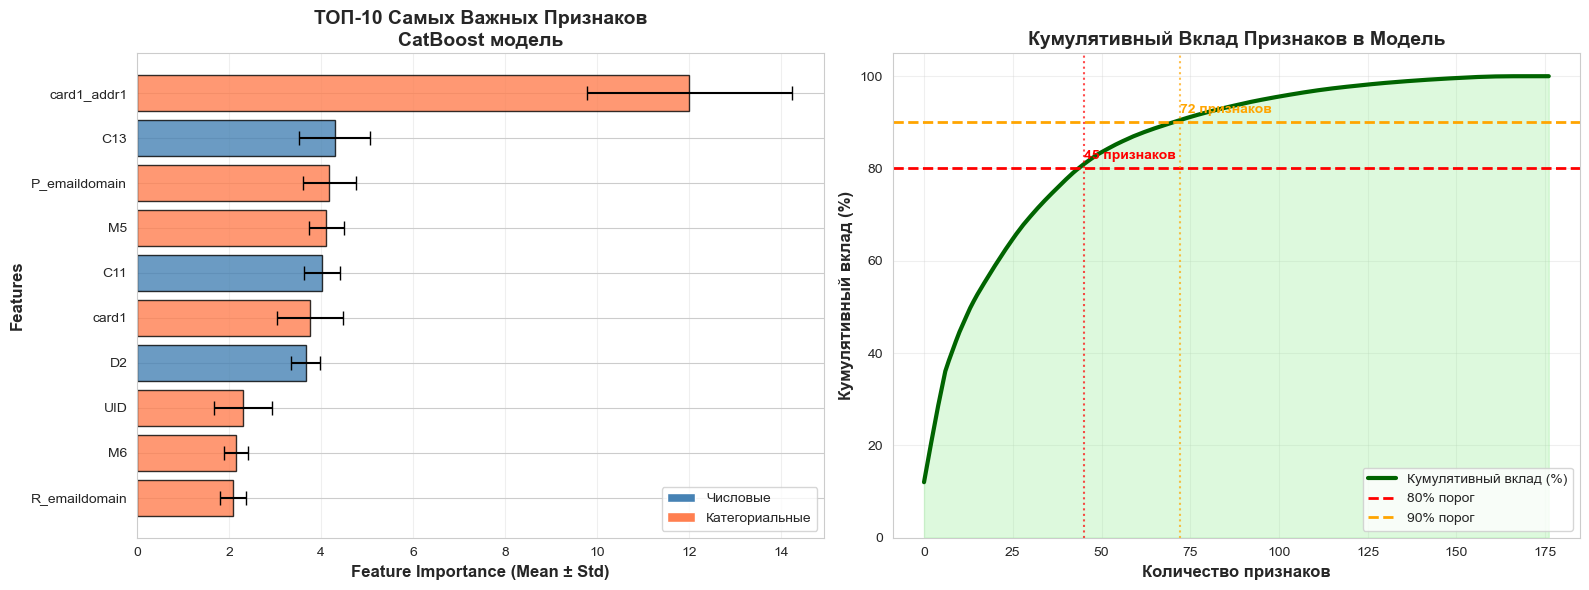


📊 АНАЛИЗ КУМУЛЯТИВНОГО ВКЛАДА ПРИЗНАКОВ:
  • Для достижения 80% важности требуется: 45 признаков (25.4%)
  • Для достижения 90% важности требуется: 72 признаков (40.7%)
  • Общее количество признаков: 177

🎯 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ

📊 ОПТИМАЛЬНЫЕ ПОРОГИ:
   По F1-Score:        0.85 (F1=0.5711)
   По бизнес-стоимости: 0.60 (Cost=$149,780)
   Дефолтный порог:     0.50

✅ ВЫБРАН ПОРОГ: 0.60 (минимизация бизнес-стоимости)


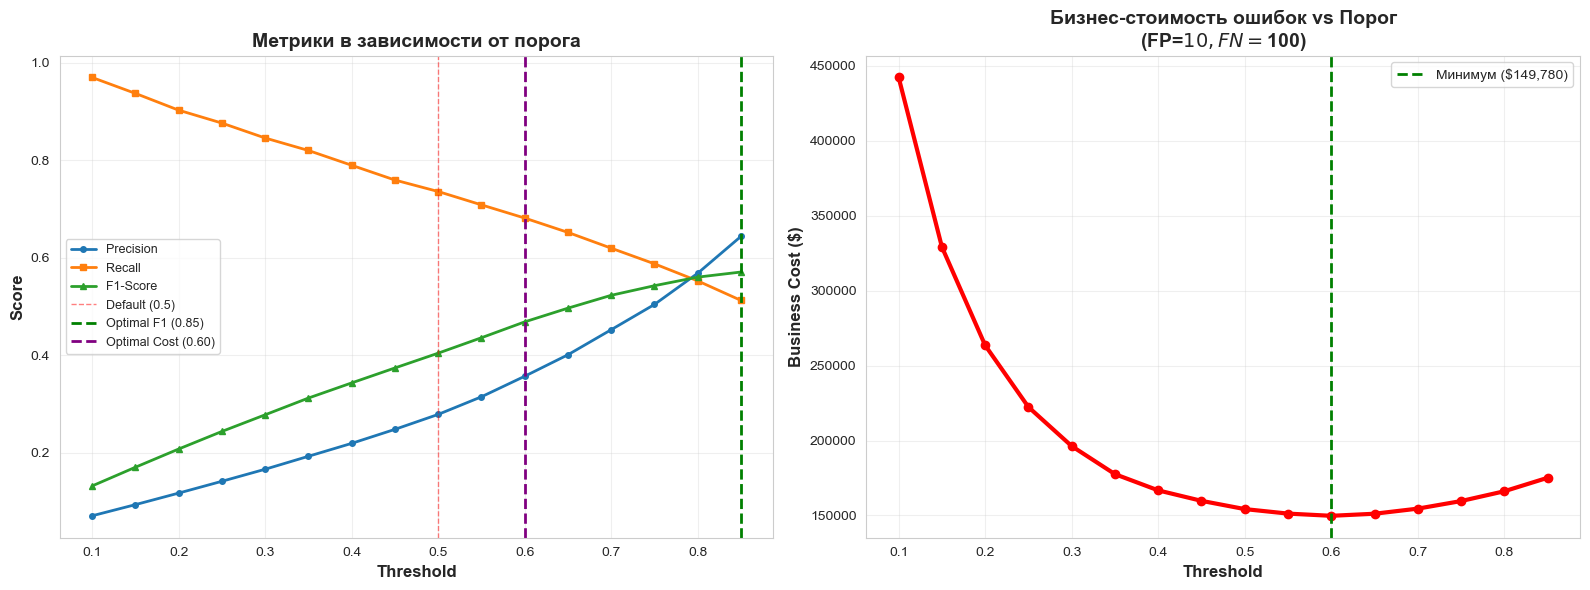


МЕТРИКИ НА ТЕСТОВОЙ ЧАСТИ ОПТИМАЛЬНЫЙ ПОРОГ 0.60

ROC-AUC:   0.9296
Accuracy:  0.9467
Precision: 0.3572
Recall:    0.6818
F1-Score:  0.4688

💰 БИЗНЕС-МЕТРИКИ:
   False Positives:  4168 × $10 = $41,680
   False Negatives:  1081 × $100 = $108,100
   Общая стоимость:  $149,780

ПОСТРОЕНИЕ ГРАФИКОВ (Optimal Threshold 0.60)
ROC-AUC: 0.9296
PR-AUC (Average Precision): 0.5805


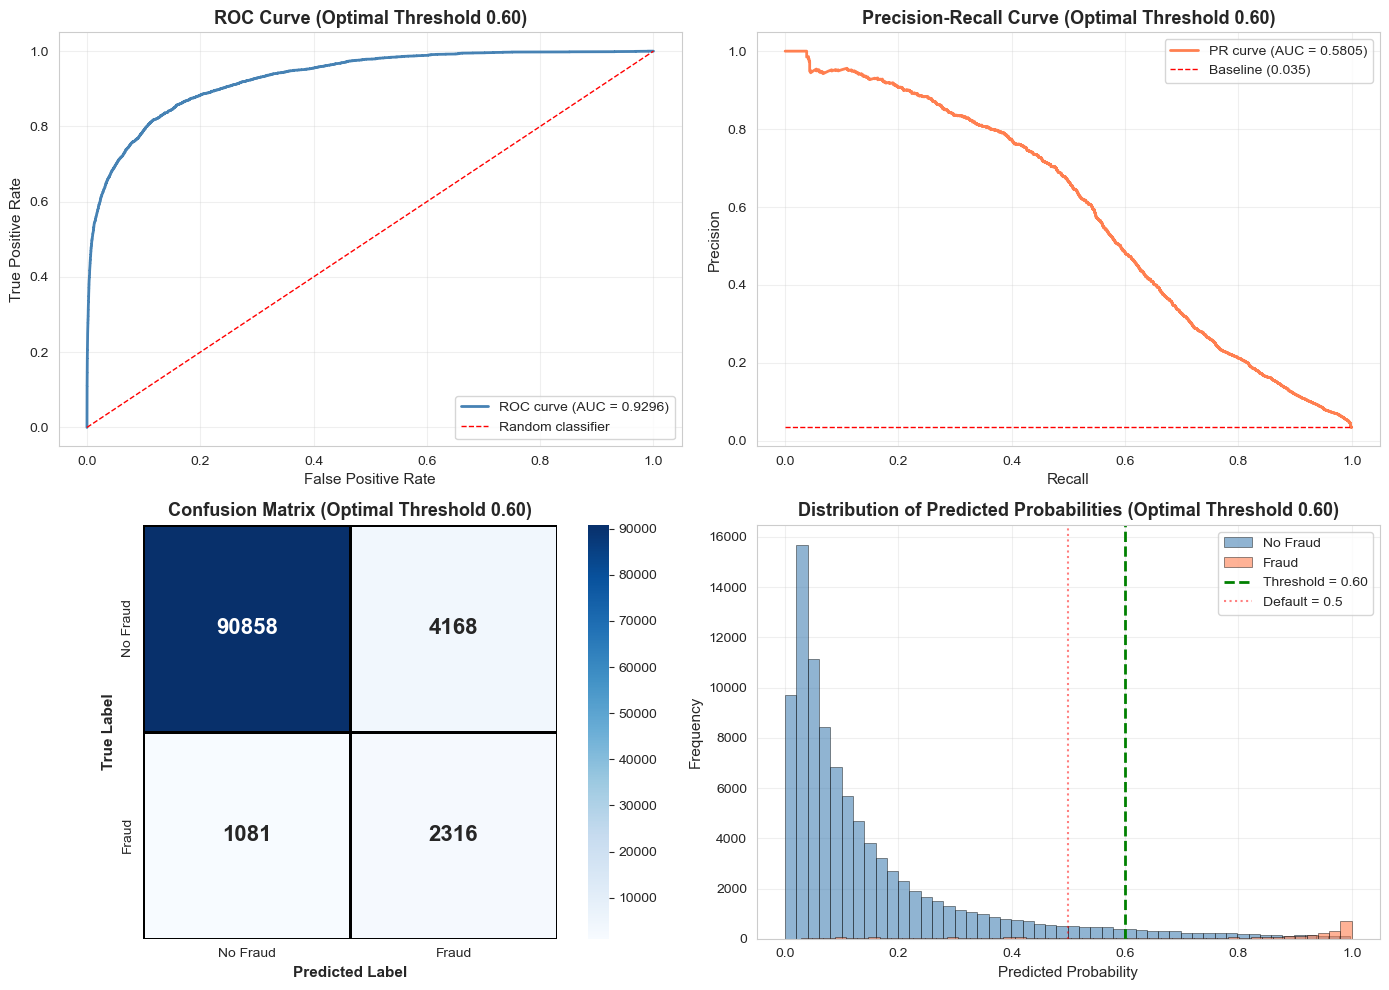


ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX (ПОРОГ 0.60)

                  Predicted
              No Fraud  |  Fraud
         ─────────────────────────
Actual   |              |        
No Fraud |     90858  |    4168
  Fraud  |      1081  |    2316

╔════════════════════════════════════════════╗
║  True Negatives  (TN):  90858 (92.31%)  ║
║  False Positives (FP):   4168 ( 4.23%)  ║
║  False Negatives (FN):   1081 ( 1.10%)  ║
║  True Positives  (TP):   2316 ( 2.35%)  ║
╚════════════════════════════════════════════╝

Дополнительные метрики из CM:
  Sensitivity (TPR, Recall): 0.6818  # доля найденного фрода
  Specificity (TNR):         0.9561  # доля правильно распознанных не-фродов
  False Positive Rate (FPR): 0.0439     # доля ложных тревог
  False Negative Rate (FNR): 0.3182     # доля пропущенного фрода

CLASSIFICATION REPORT (ПОРОГ 0.60)
              precision    recall  f1-score   support

    No Fraud       0.99      0.96      0.97     95026
       Fraud       0.36      0.68      0.47  

In [22]:
# ============================================================================
# ПОДГОТОВКА ДАННЫХ
# ============================================================================

# КРИТИЧНО! Сортируем по времени
train = train.sort_values('TransactionDT').reset_index(drop=True)

# Разделим X и y
X = train.drop('isFraud', axis=1)
y = train['isFraud']

X = X.loc[train.index]
y = y.loc[train.index]

print("✅ Отсортировано по TransactionDT")
print(f"Время: {train['TransactionDT'].min()} - {train['TransactionDT'].max()}")

# ============================================================================
# ОПРЕДЕЛЕНИЕ И ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ============================================================================

print("\n🔧 Определение категориальных признаков...")
categorical_features = get_categorical_features(X)

# Преобразуем категориальные признаки
X, categorical_features = prepare_categorical_features(X, categorical_features)

# Получаем индексы категориальных признаков для CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

print(f"\n✅ Обработано {len(categorical_features)} категориальных признаков")
print(f"   Примеры: {', '.join(categorical_features[:5])}")

# ============================================================================
# ПРОВЕРКА НА NaN И ДИСБАЛАНС КЛАССОВ
# ============================================================================

print(f"\n🔍 ПРОВЕРКА ДАННЫХ:")
nan_count = X.isna().sum().sum()
if nan_count > 0:
    print(f"⚠️  Найдено {nan_count} пропущенных значений в числовых признаках")
    print(f"   CatBoost обработает их автоматически через nan_mode='Min'")
else:
    print(f"✅ Пропущенных значений не обнаружено")

# Проверка дисбаланса классов
fraud_rate = y.mean()
print(f"\n📊 ДИСБАЛАНС КЛАССОВ:")
print(f"   Fraud: {y.sum()} ({fraud_rate*100:.2f}%)")
print(f"   No Fraud: {len(y) - y.sum()} ({(1-fraud_rate)*100:.2f}%)")
print(f"   Соотношение: 1:{int(1/fraud_rate)}")

# Вычисляем scale_pos_weight для балансировки
scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"   Scale_pos_weight для CatBoost: {scale_pos_weight:.2f}")

# ============================================================================
# CROSS-VALIDATION С CATBOOST
# ============================================================================

from sklearn.model_selection import TimeSeriesSplit
import catboost as cb

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))

print("\n" + "="*100)
print("🏋️ CatBoost + TimeSeriesSplit CV")
print("="*100)

# Параметры CatBoost
catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.05,
    'depth': 7,
    'l2_leaf_reg': 3.0,
    'min_data_in_leaf': 50,
    'subsample': 0.8,
    'rsm': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'cat_features': cat_features_indices,
    'nan_mode': 'Min',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'task_type': 'CPU',  # Или 'GPU' если доступно
    'random_seed': 42,
    'verbose': 0
}

auc_scores = []
importance_list = []  # Сохраняем importance для каждого фолда

for fold, (train_idx, val_idx) in enumerate(splits):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Создаем Pool объекты CatBoost
    train_pool = cb.Pool(
        data=X_tr,
        label=y_tr,
        cat_features=cat_features_indices
    )
    
    val_pool = cb.Pool(
        data=X_val,
        label=y_val,
        cat_features=cat_features_indices
    )
    
    model = cb.CatBoostClassifier(**catboost_params)
    
    # Обучение с early stopping
    model.fit(
        train_pool,
        eval_set=val_pool,
        verbose=False
    )
    
    val_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)
    
    # Сохраняем feature importance
    importance_list.append(model.get_feature_importance())
    
    print(f"Fold {fold+1}: AUC={auc:.4f} | Best iteration: {model.get_best_iteration()}")

print(f"\n📊 CV AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ============================================================================
# АНАЛИЗ СТАБИЛЬНОСТИ ПРИЗНАКОВ ПО ФОЛДАМ
# ============================================================================

print(f"\n🔄 СТАБИЛЬНОСТЬ ПРИЗНАКОВ ПО ФОЛДАМ:")
print(f"{'Фолд':<10} {'Топ-1 признак':<30} {'Важность':<15}")
print(f"{'='*55}")

for fold_num, importance in enumerate(importance_list):
    top_feature_idx = np.argmax(importance)
    top_feature = X.columns[top_feature_idx]
    top_importance = importance[top_feature_idx]
    print(f"Fold {fold_num+1:<5} {top_feature:<30} {top_importance:<15.4f}")

# Усреднённая важность по всем фолдам
avg_importance = np.mean(importance_list, axis=0)
std_importance = np.std(importance_list, axis=0)

importance_df_avg = pd.DataFrame({
    'feature': X.columns.tolist(),
    'importance': avg_importance,
    'importance_std': std_importance,
    'cv_stability': std_importance / (avg_importance + 1e-10),
    'is_categorical': [col in categorical_features for col in X.columns]
}).sort_values('importance', ascending=False)

print(f"\n🔥 ТОП-10 ПРИЗНАКОВ (усреднённые по всем фолдам):")
for idx, row in importance_df_avg.head(10).iterrows():
    cat_marker = " [CAT]" if row['is_categorical'] else " [NUM]"
    print(f"   {row['feature']:20s} {cat_marker}: {row['importance']:.4f} ± {row['importance_std']:.4f}")

# ============================================================================
# ОБУЧЕНИЕ НА ПОСЛЕДНЕМ ФОЛДЕ
# ============================================================================

print("\n" + "="*100)
print("ОБУЧЕНИЕ И ПРЕДСКАЗАНИЕ НА ПОСЛЕДНЕМ ФОЛДЕ")
print("="*100)

# Берём последний фолд
train_idx_last, test_idx_last = splits[-1]
X_train_last = X.iloc[train_idx_last]
y_train_last = y.iloc[train_idx_last]
X_test_last = X.iloc[test_idx_last]
y_test_last = y.iloc[test_idx_last]

print(f"\nРазмер train (последний фолд): {len(X_train_last)}")
print(f"Размер test (последний фолд):  {len(X_test_last)}")

# Создаем Pool для последнего фолда
train_pool_last = cb.Pool(
    data=X_train_last,
    label=y_train_last,
    cat_features=cat_features_indices
)

test_pool_last = cb.Pool(
    data=X_test_last,
    label=y_test_last,
    cat_features=cat_features_indices
)

# Обучаем финальную модель
final_model = cb.CatBoostClassifier(**catboost_params)

final_model.fit(
    train_pool_last,
    eval_set=test_pool_last,
    verbose=False
)

print("✅ Модель обучена на последнем фолде")
print(f"   Best iteration: {final_model.get_best_iteration()}")

# Сохранение модели
final_model.save_model('catboost_fraud_detection_model.cbm')
print("✅ Модель сохранена в 'catboost_fraud_detection_model.cbm'")

# ============================================================================
# FEATURE IMPORTANCE (УСРЕДНЁННАЯ ПО CV)
# ============================================================================

# График важности признаков
importance_stats = plot_feature_importance(
    importance_df_avg, 
    categorical_features, 
    X.columns,
    title_prefix=""
)

# ============================================================================
# ПРЕДСКАЗАНИЯ И ОПТИМИЗАЦИЯ ПОРОГА
# ============================================================================

y_test_pred_proba = final_model.predict_proba(X_test_last)[:, 1]

# Поиск оптимального порога (по бизнес-стоимости)
threshold_results = optimize_threshold(
    y_test_last, 
    y_test_pred_proba, 
    cost_fp=10,    # Стоимость блокировки легальной транзакции
    cost_fn=100    # Стоимость пропущенного фрода
)

# Используем оптимальный порог по бизнес-стоимости
optimal_threshold = threshold_results['optimal_business']
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

print(f"\n✅ ВЫБРАН ПОРОГ: {optimal_threshold:.2f} (минимизация бизнес-стоимости)")

# Визуализация анализа порогов
plot_threshold_analysis(threshold_results)

# ============================================================================
# МЕТРИКИ С ОПТИМАЛЬНЫМ ПОРОГОМ
# ============================================================================

# Вывод основных метрик
metrics_optimal = print_model_metrics(
    y_test_last, 
    y_test_pred_proba, 
    y_test_pred, 
    fold_name=f"ОПТИМАЛЬНЫЙ ПОРОГ {optimal_threshold:.2f}"
)

# Бизнес-метрики
cm = confusion_matrix(y_test_last, y_test_pred)
tn, fp, fn, tp = cm.ravel()
business_cost = fp * threshold_results['cost_fp'] + fn * threshold_results['cost_fn']

print(f"\n💰 БИЗНЕС-МЕТРИКИ:")
print(f"   False Positives:  {fp} × ${threshold_results['cost_fp']} = ${fp*threshold_results['cost_fp']:,}")
print(f"   False Negatives:  {fn} × ${threshold_results['cost_fn']} = ${fn*threshold_results['cost_fn']:,}")
print(f"   Общая стоимость:  ${business_cost:,}")

# ============================================================================
# ВИЗУАЛИЗАЦИЯ: ROC, PR, CONFUSION MATRIX, РАСПРЕДЕЛЕНИЕ
# ============================================================================

# Графики оценки модели
plot_results = plot_model_evaluation(
    y_test_last, 
    y_test_pred_proba, 
    y_test_pred, 
    fold_name=f"Optimal Threshold {optimal_threshold:.2f}",
    threshold=optimal_threshold
)

# ============================================================================
# ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX + CLASSIFICATION REPORT
# ============================================================================

# Используем функцию для детального анализа
cm_analysis = print_confusion_matrix_analysis(
    cm, 
    y_test_last, 
    y_test_pred, 
    fold_name=f"ПОРОГ {optimal_threshold:.2f}"
)

# ============================================================================
# РЕКОМЕНДАЦИИ
# ============================================================================

print("\n" + "="*100)
print("💡 РЕКОМЕНДАЦИИ ПО ОПТИМИЗАЦИИ МОДЕЛИ")
print("="*100)

n_features_80 = importance_stats['n_features_80']
n_features_90 = importance_stats['n_features_90']

print(f"\n1. ОТБОР ПРИЗНАКОВ:")
print(f"   • {n_features_80} признаков для 80% важности")
print(f"   • Ускорение в {len(X.columns)/n_features_80:.1f} раз")

top_n_features = importance_df_avg.head(n_features_80)['feature'].tolist()
top_categorical = [f for f in top_n_features if f in categorical_features]

print(f"\n2. ТОП-{min(20, n_features_80)} ПРИЗНАКОВ:")
for i, feature in enumerate(top_n_features[:20], 1):
    cat_marker = " [CAT]" if feature in categorical_features else " [NUM]"
    print(f"   {i:2d}. {feature}{cat_marker}")

print(f"\n🎯 ROC-AUC: {metrics_optimal['auc']:.4f}")
print(f"📊 Категориальных: {len(categorical_features)} ({len(categorical_features)/len(X.columns)*100:.1f}%)")
